<font color='blue' size=5><b>Комментарий ревьюера</b></font>

<font color='blue'>Привет, Алексей! Меня зовут Павел Григорьев, и я буду проверять этот проект.<br>Моя основная цель - не указать на совершённые тобой ошибки, а поделиться своим опытом и помочь тебе совершенствоваться как профессионалу.<br>Спасибо за проделанную работу! Предлагаю общаться на «ты».</font>
<details>
	<summary><u>Инструкция по организационным моментам (кликабельно)</u></summary>
<font color='blue'>Я буду использовать различные цвета, чтобы было удобнее воспринимать мои комментарии:</font>


---


<font color='blue'>синий текст - просто текст комментария</font>

<font color='green'>✔️ и зеленый текст - все отлично</font>

<font color='orange'>⚠️ и оранжевый текст - сделано все правильно, однако есть рекомендации, на что стоит обратить внимание</font>

<font color='red'>❌ и красный текст - есть недочеты</font>


</details>    
    </br>
<font color='blue'>Пожалуйста, не удаляй мои комментарии в случае возврата работы, так будет проще разобраться, какие были недочеты, а также сразу увидеть исправленное. </font>

Ответы на мои комментарии лучше тоже помечать.
Например: <font color='purple'><b>Комментарий студента</b></font>

<font color='blue'><b>Давай смотреть, что получилось!</b></font>

# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

## Подготовка данных

In [10]:
! pip install -q jupyternotify

In [11]:
# Уведомление о завершение работы определенного ячейка (очень пригодится для машинного обучения)
import jupyternotify
%load_ext jupyternotify

<IPython.core.display.Javascript object>

In [12]:
# Подключаем все необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
from scipy import stats as st
# Время обучения модели
import timeit
from lightgbm import LGBMRegressor
# Вызов библиотеки для отключения предупреждения
import warnings

# Разбиение на обучающую, валидационную и тестовую выборку
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, cross_val_predict
# Применим кроссвалидацию для повышения качеств обучения
# Для константной модели
from sklearn.dummy import DummyRegressor
from catboost import CatBoostRegressor

# Масштабируемость модели
from sklearn.preprocessing import StandardScaler, OrdinalEncoder 

# и для машинного обучения разными способами (по условию мы выбираем линейную регрессию):
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor

from sklearn.metrics import (
    # Точность модели
    accuracy_score,
    # Матрицы ошибок (для борьбы с дисбалансом)
    confusion_matrix, 
    # Полнота
    recall_score, 
    # Точность
    precision_score, 
    # F1-мера
    f1_score,
    # Метрика AUC-ROC
    roc_auc_score,
    roc_curve,
    # MSE
    mean_squared_error,
    mean_absolute_error,
    fbeta_score, 
    make_scorer
)

# Контроль выборки
from sklearn.utils import shuffle

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Хорошее оформление импортов! \
Импорты собраны в одной ячейке, разделены на функциональные группы пустой строкой.</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='orange'> Неужели всё это понадобится в проекте? Лишние импорты лучше удалить, ведь это ненужные зависимости.</font>

### Загрузим данные

In [13]:
# Получаем датасет
try:
    # С локального файла
    try:
        df = pd.read_csv('autos.csv')
    except:
        df = pd.read_csv('/datasets/autos.csv')
except:
    print('Отсутствует датасет. Проверьте путь файла')

### Изучим данные

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

**Дополнительные информация:**

**Признаки**
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя

**Целевой признак**
- `Price` — цена (евро)

In [15]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [16]:
df.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


Тут можно заметить странное, что в колонке "год регистрации автомобиля" есть 1000 и 9999. Скорее всего это аномальное значения. Также в данный момент не существуют машин, у которых мощностей двигателя больше 143 л.с. А также странно получилось, что машина выставлена в продажах бесплатно. Ну, может быть они хотят быстрее избавиться от них, а может "ради прикола" выставили в продажах, но все равно устраняем их

Text(0, 0.5, 'Стоимость ЕВРО')

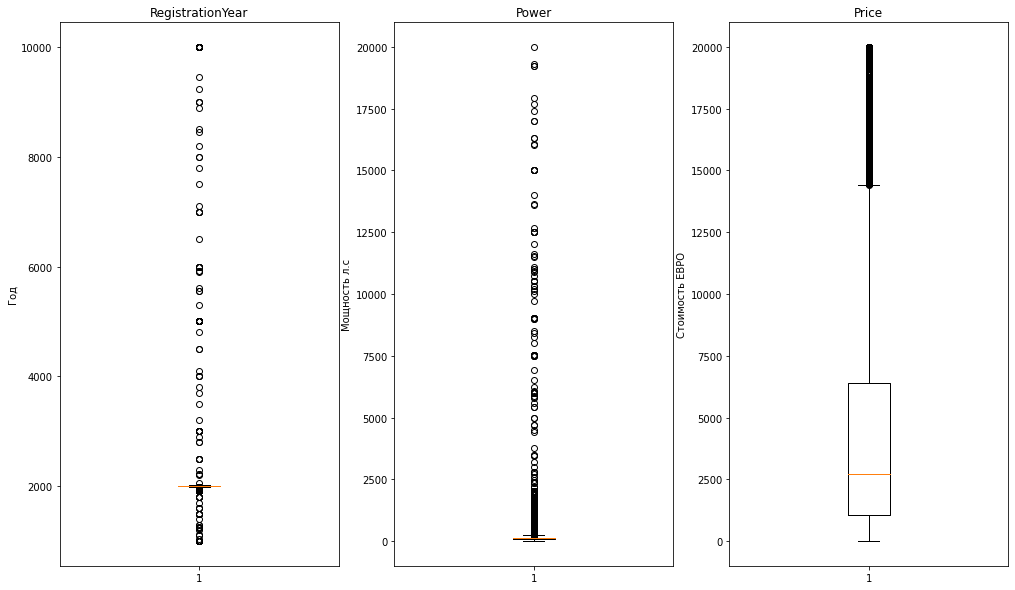

In [17]:
fig, axs = plt.subplots(1, 3, figsize=(17, 10))

axs[0].boxplot(df['RegistrationYear'])
axs[0].set_title('RegistrationYear')
axs[0].set_ylabel('Год')
        
axs[1].boxplot(df['Power'])
axs[1].set_title('Power')
axs[1].set_ylabel('Мощность л.с')

axs[2].boxplot(df['Price'])
axs[2].set_title('Price')
axs[2].set_ylabel('Стоимость ЕВРО')

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Данные загружены корректно, первичный осмотр проведен.</font>

### Заполним пропущенные значения и обработаем аномалии в столбцах. Если среди признаков имеются неинформативные, то удалим их.

In [18]:
# Скорпируем
df_clean = df.copy()

Удаляем аномальные значения

In [19]:
df_clean = df.copy()
# Очистим
# Год регистрации автомобиля
df_clean = df[df['RegistrationYear'] > (df.describe()['RegistrationYear']['50%'] - df.describe()['RegistrationYear']['std'])]
df_clean = df_clean[df_clean['RegistrationYear'] < 2023]

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Обрати внимание на даты в DateCrawled в сравнении с RegistrationYear</font>

In [20]:
# Мощность двигателя л.с
df_clean = df_clean[df_clean['Power'] > abs(df_clean.describe()['Power']['50%'] - df_clean.describe()['Power']['std'])]
df_clean = df_clean[df_clean['Power'] < abs(df_clean.describe()['Power']['75%'] + df_clean.describe()['Power']['std'])]

In [21]:
# Бесплатные автомобили и слишком дешевые автомобили
df_clean = df_clean[df_clean['Price'] > abs(df_clean.describe()['Price']['50%'] - df_clean.describe()['Price']['std'])]

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>Выбросить машину в Германии удовольствие не из дешёвых, я бы не считал дешёвые машины аномалией ))</font>

In [22]:
df_clean.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,202868.000000,202868.000000,202868.000000,202868.000000,202868.000000,202868.0,202868.000000
mean,6243.655318,2004.211334,143.444417,129597.447601,6.121646,0.0,52105.827829
std,4797.468519,6.343907,46.619757,35773.573448,3.540755,0.0,25906.456594
min,780.000000,1937.000000,85.000000,5000.000000,0.000000,0.0,1067.000000
25%,2399.000000,2000.000000,109.000000,125000.000000,3.000000,0.0,31552.000000
50%,4800.000000,2005.000000,136.000000,150000.000000,6.000000,0.0,51429.000000
75%,8990.000000,2008.000000,165.000000,150000.000000,9.000000,0.0,73066.000000
max,20000.000000,2019.000000,390.000000,150000.000000,12.000000,0.0,99998.000000


Text(0, 0.5, 'Стоимость ЕВРО')

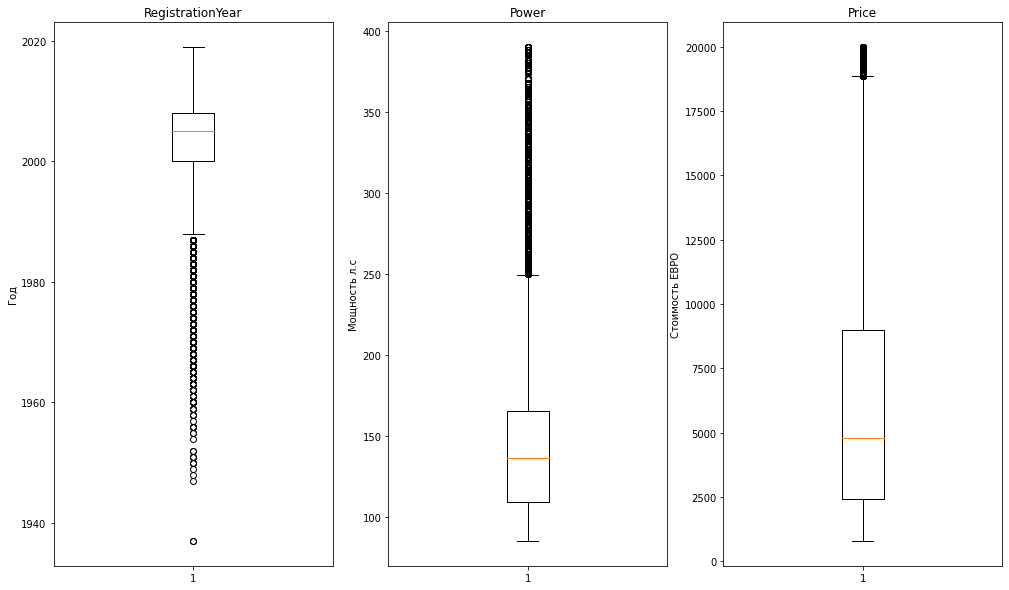

In [23]:
fig, axs = plt.subplots(1, 3, figsize=(17, 10))

axs[0].boxplot(df_clean['RegistrationYear'])
axs[0].set_title('RegistrationYear')
axs[0].set_ylabel('Год')
        
axs[1].boxplot(df_clean['Power'])
axs[1].set_title('Power')
axs[1].set_ylabel('Мощность л.с')

axs[2].boxplot(df_clean['Price'])
axs[2].set_title('Price')
axs[2].set_ylabel('Стоимость ЕВРО')

In [24]:
# Преобразуем на другой тип данных DateCrawled, DateCreated и LastSeen
df_clean['DateCrawled'] = pd.to_datetime(df_clean['DateCrawled'])
df_clean['DateCreated'] = pd.to_datetime(df_clean['DateCreated'])
df_clean['LastSeen'] = pd.to_datetime(df_clean['LastSeen'])

In [44]:
f'Потеряно {100 * (1 - df_clean.shape[0] / df.shape[0])}%'

'Потеряно 42.75232878722461%'

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> Нужно оставить хотя бы 70 % данных.</font>

#### Пропущенные значения

Устранили аномальные значения, теперь смотрим кол-во пропущенных значений. Попробуем разбить 2 датасет, один из которых будет применять радикальным способом - устранять их насовсем. Второй - заполнение `"unknown"` или медиальным значением.

In [26]:
df_clean.isna().sum()

DateCrawled              0
Price                    0
VehicleType          11090
RegistrationYear         0
Gearbox               2555
Power                    0
Model                 7150
Kilometer                0
RegistrationMonth        0
FuelType             10338
Brand                    0
Repaired             25729
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [27]:
len(df_clean)

202868

##### Первый способ - радикальный

Тип автомобилей, коробки передачи, модели, топлива и состояния ремонта мы не можем поставить усредненные значения, т.к. это является уникальными. Но у нас достаточно информаций, чтобы можно устранять эти нежелательные пропуски

In [28]:
# Скорпируем
df_clean_rad = df_clean.copy()

In [29]:
# Устраняем
df_clean_rad = df_clean_rad[~df_clean_rad['VehicleType'].isna()]
df_clean_rad = df_clean_rad[~df_clean_rad['Gearbox'].isna()]
df_clean_rad = df_clean_rad[~df_clean_rad['Model'].isna()]
df_clean_rad = df_clean_rad[~df_clean_rad['FuelType'].isna()]
df_clean_rad = df_clean_rad[~df_clean_rad['Repaired'].isna()]

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> Слишком большая потеря данных. Тесты будут невалидными.</font>

In [30]:
# Проверим
df_clean_rad.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [31]:
# Сбрасываем и снова пронумерируем индексы
df_clean_rad = df_clean_rad.reset_index(drop=True)

In [32]:
# Преобразуем на другой тип данных DateCrawled, DateCreated и LastSeen
df_clean_rad['DateCrawled'] = pd.to_datetime(df_clean_rad['DateCrawled'])
df_clean_rad['DateCreated'] = pd.to_datetime(df_clean_rad['DateCreated'])
df_clean_rad['LastSeen'] = pd.to_datetime(df_clean_rad['LastSeen'])

In [33]:
df_clean_rad.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
1,2016-03-26 19:54:18,2000,sedan,2004,manual,105,3_reihe,150000,12,petrol,mazda,no,2016-03-26,0,96224,2016-04-06 10:45:34
2,2016-04-07 10:06:22,2799,wagon,2005,manual,140,passat,150000,12,gasoline,volkswagen,yes,2016-04-07,0,57290,2016-04-07 10:25:17
3,2016-03-21 12:57:01,17999,suv,2011,manual,190,navara,70000,3,gasoline,nissan,no,2016-03-21,0,4177,2016-04-06 07:45:42
4,2016-03-23 15:48:05,7550,bus,2007,manual,136,c_max,150000,6,gasoline,ford,no,2016-03-23,0,88361,2016-04-05 18:45:11


In [34]:
len(df_clean_rad)

162507

##### Второй способ - заполнение `"unknown"` или медианным значением 

In [35]:
# Скорпируем датафрейм
df_clean_fill = df_clean.copy()

In [36]:
# Заполним значением "unknown"
df_clean_fill['VehicleType'] = df_clean_fill['VehicleType'].fillna('unknown')
df_clean_fill['Gearbox'] = df_clean_fill['Gearbox'].fillna('unknown')
df_clean_fill['Model'] = df_clean_fill['Model'].fillna('unknown')
df_clean_fill['FuelType'] = df_clean_fill['FuelType'].fillna('unknown')
df_clean_fill['Repaired'] = df_clean_fill['Repaired'].fillna('unknown')

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Пропуски заполнены достаточно безопасно.
</font>

In [37]:
# Проверим
df_clean_fill.isna().sum()

DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64

In [38]:
df_clean_fill.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,unknown,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-04-05 12:47:46
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01,0,67112,2016-04-05 18:18:39
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,unknown,2016-04-04,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,unknown,volkswagen,unknown,2016-03-17,0,27472,2016-03-31 17:17:06


In [39]:
len(df_clean_fill)

202868

Теперь с данными в порядке, можно уже приступать к обучению моделей

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>  Обрати внимание на уникальные значения в "registration_month"</font>

## Обучение моделей первого датасета

Перед обучением нужно сделать следующие: прямое кодирование, порядкое кодирование и масштабируемость модели. Поэтому обучение моделей будет разделен на 3 этапа: OH, OHE, SCALER. А также обучение будет проводиться кроссвалидацией

Поскольку у нас присутствуют некоторые признаки, которые являются строковыми или ojbect типами, а для машинного обучения регрессионного типа требует числа. Поэтому примением кодировку, которая будет преобразовать в числа

In [40]:
df_clean_rad.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162507 entries, 0 to 162506
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   DateCrawled        162507 non-null  datetime64[ns]
 1   Price              162507 non-null  int64         
 2   VehicleType        162507 non-null  object        
 3   RegistrationYear   162507 non-null  int64         
 4   Gearbox            162507 non-null  object        
 5   Power              162507 non-null  int64         
 6   Model              162507 non-null  object        
 7   Kilometer          162507 non-null  int64         
 8   RegistrationMonth  162507 non-null  int64         
 9   FuelType           162507 non-null  object        
 10  Brand              162507 non-null  object        
 11  Repaired           162507 non-null  object        
 12  DateCreated        162507 non-null  datetime64[ns]
 13  NumberOfPictures   162507 non-null  int64   

Как и видим, что существуют несколько признаков, имеющих типа object. Теперь создадим список, который автоматически заполняет определенный тип

In [45]:
# Здесь будем сохранить результаты машинного обучения
results_rad = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

### Прямое кодирование - One-Hot Encoding

In [46]:
# Убираем лишние признаки перед прямым кодированием
df_ohe = df_clean_rad[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired']]

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'> Здесь хорошо бы посмотреть дубликаты.</font>

In [47]:
# Уклоняемся от дамми-ловушек
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>Хороший инструмент для быстрого анализа, но для новых данных если набор категорий будет отличаться, получить данные с такой-же размерностью будет нельзя. Для возможности работы модели с новыми данными нужен OneHotEncoder.</font>

In [48]:
df_ohe.head()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,...,Brand_saab,Brand_seat,Brand_skoda,Brand_smart,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_volkswagen,Brand_volvo,Repaired_yes
0,2200,2004,109,150000,8,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2000,2004,105,150000,12,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2799,2005,140,150000,12,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1
3,17999,2011,190,70000,3,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,7550,2007,136,150000,6,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Деление на обучающей и валидационной выборки

In [49]:
# Получаем признак и цель 
features = df_ohe.drop('Price', axis=1)
target = df_ohe['Price']

In [50]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Здорово , что у нас есть выборка для тестов!</font>

#### LinearRegression

In [51]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 2, scoring = 'neg_root_mean_squared_error')

In [52]:
%%notify -m "LinearRegression OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 2615.507076605978
CPU times: user 17.7 s, sys: 16.8 s, total: 34.5 s
Wall time: 34.5 s


<IPython.core.display.Javascript object>

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Кодирование признков соответсвует модели!</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Классно , что применена кроссвалидация!</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> Время обучения модели нужно измерить без подбора гиперпараметров и кроссвалидации. Сетка параметров у моделей разная и сравнивать время их перебора некорректно.</font>

<font color='blue'><b>Комментарий ревьюера : </b></font>\
<font color='blue'>Время обучения модели с лучшими параметрами на всех данных (в конце подбора) можно вытащить как  `model.refit_time_`</font>

**Проверка на тестовой выборки**

In [53]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6594.010577510046
CPU times: user 184 ms, sys: 101 ms, total: 286 ms
Wall time: 271 ms


In [54]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LinearRegression_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### DecisionTreeRegressor

In [55]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [56]:
%%notify -m "DecisionTreeRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

RMSE: 3724.913236021877
CPU times: user 3.13 s, sys: 1.33 s, total: 4.46 s
Wall time: 4.47 s


<IPython.core.display.Javascript object>

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Подбор гиперпараметров проведён верно!</font>

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> Модели основанные на деревьях (все модели в проекте кроме Линейной) могут работать с порядковым кодированием категорий (OrdinalEncoding). OHE сильно раздувает размерность данных, что сказывается на вычислительной нагрузке (времени).</font>

**Проверка на тестовой выборки**

In [57]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

Предсказание: 6592.8567741947145
CPU times: user 67.1 ms, sys: 57.2 ms, total: 124 ms
Wall time: 126 ms


In [58]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### RandomForestRegressor

In [ ]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5], 'max_features': ['auto', 'log2'], 'n_estimators': [50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "RandomForestRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### LightGBMRegressor

In [59]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LightGBMRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [62]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LGBMRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### CatBoostRegressor

In [63]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [64]:
%%notify -m "CatBoostRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

0:	learn: 4846.9875114	total: 64.3ms	remaining: 579ms
1:	learn: 4814.7822695	total: 76.6ms	remaining: 306ms
2:	learn: 4783.1585938	total: 88.4ms	remaining: 206ms
3:	learn: 4751.5357796	total: 101ms	remaining: 151ms
4:	learn: 4720.5355666	total: 113ms	remaining: 113ms
5:	learn: 4689.5482800	total: 125ms	remaining: 83.3ms
6:	learn: 4659.1387398	total: 137ms	remaining: 58.9ms
7:	learn: 4629.5570054	total: 150ms	remaining: 37.5ms
8:	learn: 4600.2961044	total: 162ms	remaining: 18ms
9:	learn: 4571.1079682	total: 174ms	remaining: 0us
0:	learn: 4857.7084733	total: 12.1ms	remaining: 108ms
1:	learn: 4825.6369719	total: 24.3ms	remaining: 97ms
2:	learn: 4793.6930863	total: 36.3ms	remaining: 84.7ms
3:	learn: 4761.9419033	total: 48.3ms	remaining: 72.4ms
4:	learn: 4731.0998258	total: 64.9ms	remaining: 64.9ms
5:	learn: 4700.2584169	total: 77.3ms	remaining: 51.5ms
6:	learn: 4669.6469382	total: 88.6ms	remaining: 38ms
7:	learn: 4639.8234468	total: 100ms	remaining: 25ms
8:	learn: 4610.7007442	total: 111ms

0:	learn: 4857.7084733	total: 12.4ms	remaining: 174ms
1:	learn: 4825.6369719	total: 25.7ms	remaining: 167ms
2:	learn: 4793.6930863	total: 39ms	remaining: 156ms
3:	learn: 4761.9419033	total: 52.9ms	remaining: 146ms
4:	learn: 4731.0998258	total: 67.7ms	remaining: 135ms
5:	learn: 4700.2584169	total: 82.9ms	remaining: 124ms
6:	learn: 4669.6469382	total: 97.8ms	remaining: 112ms
7:	learn: 4639.8234468	total: 112ms	remaining: 98.2ms
8:	learn: 4610.7007442	total: 127ms	remaining: 84.9ms
9:	learn: 4581.2979460	total: 142ms	remaining: 70.8ms
10:	learn: 4552.3247096	total: 155ms	remaining: 56.2ms
11:	learn: 4523.5174274	total: 169ms	remaining: 42.2ms
12:	learn: 4495.7707845	total: 183ms	remaining: 28.2ms
13:	learn: 4467.7304809	total: 196ms	remaining: 14ms
14:	learn: 4440.0186490	total: 209ms	remaining: 0us
0:	learn: 4849.8471286	total: 13.1ms	remaining: 183ms
1:	learn: 4817.5750112	total: 25.5ms	remaining: 166ms
2:	learn: 4786.0378389	total: 38.3ms	remaining: 153ms
3:	learn: 4754.7076382	total: 

0:	learn: 4559.9618727	total: 12.7ms	remaining: 178ms
1:	learn: 4279.5310611	total: 26.2ms	remaining: 170ms
2:	learn: 4031.4297395	total: 39.3ms	remaining: 157ms
3:	learn: 3809.1566353	total: 55.2ms	remaining: 152ms
4:	learn: 3623.8783161	total: 67.8ms	remaining: 136ms
5:	learn: 3451.8676600	total: 82.5ms	remaining: 124ms
6:	learn: 3306.6503826	total: 95.7ms	remaining: 109ms
7:	learn: 3181.4892459	total: 109ms	remaining: 95.5ms
8:	learn: 3065.8433098	total: 121ms	remaining: 80.8ms
9:	learn: 2965.2505692	total: 134ms	remaining: 66.9ms
10:	learn: 2880.3399446	total: 149ms	remaining: 54.3ms
11:	learn: 2804.6952275	total: 162ms	remaining: 40.4ms
12:	learn: 2737.8750797	total: 174ms	remaining: 26.8ms
13:	learn: 2676.6330330	total: 186ms	remaining: 13.3ms
14:	learn: 2622.9051614	total: 199ms	remaining: 0us
0:	learn: 4563.1259615	total: 12.7ms	remaining: 178ms
1:	learn: 4283.8653237	total: 24.9ms	remaining: 162ms
2:	learn: 4032.5433626	total: 37.9ms	remaining: 152ms
3:	learn: 3818.0191979	tot

14:	learn: 3258.1446806	total: 210ms	remaining: 69.9ms
15:	learn: 3196.3796044	total: 222ms	remaining: 55.5ms
16:	learn: 3138.1241643	total: 234ms	remaining: 41.3ms
17:	learn: 3082.3503876	total: 246ms	remaining: 27.4ms
18:	learn: 3030.5557277	total: 258ms	remaining: 13.6ms
19:	learn: 2982.3382512	total: 271ms	remaining: 0us
0:	learn: 4731.9044004	total: 12.8ms	remaining: 244ms
1:	learn: 4580.3316859	total: 25.9ms	remaining: 233ms
2:	learn: 4435.9166770	total: 38.6ms	remaining: 219ms
3:	learn: 4302.2976081	total: 52.8ms	remaining: 211ms
4:	learn: 4177.4411107	total: 68.1ms	remaining: 204ms
5:	learn: 4057.7234587	total: 80.8ms	remaining: 189ms
6:	learn: 3946.3398427	total: 93.5ms	remaining: 174ms
7:	learn: 3839.7118182	total: 106ms	remaining: 159ms
8:	learn: 3742.6253963	total: 119ms	remaining: 145ms
9:	learn: 3647.7980268	total: 131ms	remaining: 131ms
10:	learn: 3560.6726986	total: 143ms	remaining: 117ms
11:	learn: 3478.3911352	total: 155ms	remaining: 103ms
12:	learn: 3400.5127211	tota

16:	learn: 2533.3205203	total: 217ms	remaining: 38.2ms
17:	learn: 2496.7707795	total: 227ms	remaining: 25.3ms
18:	learn: 2464.0368056	total: 239ms	remaining: 12.6ms
19:	learn: 2433.8885136	total: 255ms	remaining: 0us
0:	learn: 4552.4758583	total: 12.3ms	remaining: 234ms
1:	learn: 4270.5765479	total: 24.6ms	remaining: 221ms
2:	learn: 4022.0072408	total: 37.2ms	remaining: 211ms
3:	learn: 3806.7013798	total: 49.2ms	remaining: 197ms
4:	learn: 3619.0282410	total: 61.1ms	remaining: 183ms
5:	learn: 3456.7036092	total: 74.7ms	remaining: 174ms
6:	learn: 3310.2661438	total: 88.7ms	remaining: 165ms
7:	learn: 3182.9727599	total: 103ms	remaining: 154ms
8:	learn: 3071.9604359	total: 126ms	remaining: 154ms
9:	learn: 2970.9589055	total: 145ms	remaining: 145ms
10:	learn: 2885.8199568	total: 163ms	remaining: 134ms
11:	learn: 2812.3471591	total: 175ms	remaining: 117ms
12:	learn: 2745.5748527	total: 187ms	remaining: 101ms
13:	learn: 2684.3373525	total: 199ms	remaining: 85.1ms
14:	learn: 2632.1173870	total

KeyboardInterrupt: 

<IPython.core.display.Javascript object>

<font color='blue'><b>Комментарий ревьюера: </b></font> ⚠️\
<font color='darkorange'>CatBoost может сам кодировать категории из типа данных 'object' и 'category', но эта кодровка занимает дополнительное время. Если кодировать OE, то получатся быстрее.</font>

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [66]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

### Порядковое кодирование - OrdinalEncoder

In [ ]:
col_type_obj = []

for i, name in enumerate(df_clean_rad.columns):
    if(df_clean_rad[name].dtype == object):
        print(i, name)
        col_type_obj.append(name)

print()
print('Список:', col_type_obj)

Теперь преобразуем в другой тип, применяя OrdinalEncoder

In [ ]:
df_mini_oe = pd.DataFrame(OrdinalEncoder().fit_transform(df_clean_rad[col_type_obj]), columns=col_type_obj)
df_mini_oe

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> Энкодер (как и Скалер) нельзя обучать на полных данных.\
Для вычисления трансформаций они используют информацию о всех поданных в них данных и обучение на полных данных приводит к утечке из обучающей выборки во все остальные. Тестовые и валидационные выборки можно только трансформировать, предобработчиками обученными на train.</font>

Теперь создадим датасет, в котором содержатся исключительно цифры

In [ ]:
# Устраняем столбцы, в котором содержатся типы object
df_oe = df_clean_rad.drop(columns=col_type_obj)

# Сбросим индексы 
df_oe = df_oe.reset_index(drop=True)

# Добавим колонку в текущий датасет
df_oe = pd.concat([df_oe, df_mini_oe], axis=1)

In [ ]:
df_oe.head()

#### Деление на обучающей и валидационной выборки

In [ ]:
features = df_oe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_oe['Price']

In [ ]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

#### LinearRegression

In [ ]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LinearRegression OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

<font color='blue'><b>Комментарий ревьюера: </b></font> ❌\
<font color='red'> Линейные модели требуют OHE кодировки категорий.</font>

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LinearRegression_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### DecisionTreeRegressor

In [ ]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "DecisionTreeRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'> Кодирование признков соответсвует модели!</font>

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### RandomForestRegressor

In [ ]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "RandomForestRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### LightGBMRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LightGBMRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LGBMRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### CatBoostRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "CatBoostRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

### Масштабирование признаков - StandardScaler

#### Масштабируем OHE

##### Деление на обучающей и валидационной выборки

In [ ]:
features = df_ohe.drop(['Price'], axis=1)
target = df_ohe['Price']

In [ ]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

In [ ]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Отлично, что scaler был обучен только на тренировочной части данных!</font>

In [ ]:
# Проверим
print(features_train.shape)
print(features_valid.shape)

In [ ]:
features_train.head()

##### LinearRegression

In [ ]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LinearRegression OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LinearRegression_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### DecisionTreeRegressor

In [ ]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "DecisionTreeRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### RandomForestRegressor

In [ ]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "RandomForestRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### LightGBMRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LightGBMRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LGBMRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### CatBoostRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "CatBoostRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### Масштабируем OE

##### Деление на обучающей и валидационной выборки

In [ ]:
features = df_oe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_oe['Price']

In [ ]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

In [ ]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

numeric = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [ ]:
# Проверим
print(features_train.shape)
print(features_valid.shape)

In [ ]:
features_train.head()

##### LinearRegression

In [ ]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LinearRegression OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LinearRegression_OE_C','RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### DecisionTreeRegressor

In [ ]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "DecisionTreeRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OE_C','RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### RandomForestRegressor

In [ ]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "RandomForestRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

##### LightGBMRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LightGBMRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'LightGBMRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

#### CatBoostRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "CatBoostRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_rad[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_rad[count_model]
count_model+=1

## Обучение моделей второго датасета

In [ ]:
df_clean_fill.info()

In [ ]:
# Здесь будем сохранить результаты машинного обучения
results_fill = pd.DataFrame()

# А это будет счетчтиком для нумерация моеделй
count_model = 0

### Прямое кодирование - One-Hot Encoding

In [ ]:
# Убираем лишние признаки перед прямым кодированием
df_ohe = df_clean_fill[['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand',
       'Repaired']]

In [ ]:
# Уклоняемся от дамми-ловушек
df_ohe = pd.get_dummies(df_ohe, drop_first=True)

In [ ]:
df_ohe.head()

#### Деление на обучающей и валидационной выборки

In [ ]:
# Получаем признак и цель 
features = df_ohe.drop('Price', axis=1)
target = df_ohe['Price']

In [ ]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

#### LinearRegression

In [ ]:
# Устанавливаем нужные параметры
parameters = {}
count_model = 0

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 2, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LinearRegression OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LinearRegression_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### DecisionTreeRegressor

In [ ]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "DecisionTreeRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### RandomForestRegressor

In [ ]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5], 'max_features': ['auto', 'log2'], 'n_estimators': [50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "RandomForestRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### LightGBMRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LightGBMRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LGBMRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### CatBoostRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "CatBoostRegressor OHE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OHE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

### Порядковое кодирование - OrdinalEncoder

In [ ]:
df_mini_oe = pd.DataFrame(OrdinalEncoder().fit_transform(df_clean_fill[col_type_obj]), columns=col_type_obj)
df_mini_oe

Теперь создадим датасет, в котором содержатся исключительно цифры

In [ ]:
# Устраняем столбцы, в котором содержатся типы object
df_oe = df_clean_fill.drop(columns=col_type_obj)

# Сбросим индексы
df_oe = df_oe.reset_index(drop=True)

# Добавим колонку в текущий датасет
df_oe = pd.concat([df_oe, df_mini_oe], axis=1)

In [ ]:
df_oe.head()

#### Деление на обучающей и валидационной выборки

In [ ]:
features = df_oe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_oe['Price']

In [ ]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

#### LinearRegression

In [ ]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LinearRegression OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LinearRegression_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### DecisionTreeRegressor

In [ ]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "DecisionTreeRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### RandomForestRegressor

In [ ]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "RandomForestRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### LightGBMRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LightGBMRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LGBMRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### CatBoostRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "CatBoostRegressor OE"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OE', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

### Масштабирование признаков - StandardScaler

#### Масштабируем OHE

##### Деление на обучающей и валидационной выборки

In [ ]:
features = df_ohe.drop(['Price'], axis=1)
target = df_ohe['Price']

In [ ]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

In [ ]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

numeric = ['RegistrationYear', 'Power', 'Kilometer', 'RegistrationMonth']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [ ]:
# Проверим
print(features_train.shape)
print(features_valid.shape)

In [ ]:
features_train.head()

##### LinearRegression

In [ ]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LinearRegression OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LinearRegression_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### DecisionTreeRegressor

In [ ]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "DecisionTreeRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### RandomForestRegressor

In [ ]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "RandomForestRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### LightGBMRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LightGBMRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LGBMRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### CatBoostRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "CatBoostRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OHE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### Масштабируем OE

##### Деление на обучающей и валидационной выборки

In [ ]:
features = df_oe.drop(['Price', 'DateCrawled', 'DateCreated', 'LastSeen'], axis=1)
target = df_oe['Price']

In [ ]:
# Разделим обучающую и валидационную выборку
features_train, features_valid, target_train, target_valid = train_test_split(features, target, test_size=(1 - 0.6), random_state=12345)

In [ ]:
# Масштабируем признаки: обучающую, валидационную и тестовую выборку
scaler = StandardScaler()

numeric = ['VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model', 'Kilometer', 'RegistrationMonth', 'FuelType', 'Brand', 'Repaired']

scaler.fit(features_train[numeric])

# Преобразуем обучающую, валидационную и тестовую выборки функцией transform()
features_train[numeric] = scaler.transform(features_train[numeric])
features_valid[numeric] = scaler.transform(features_valid[numeric])

In [ ]:
# Проверим
print(features_train.shape)
print(features_valid.shape)

In [ ]:
features_train.head()

##### LinearRegression

In [ ]:
# Устанавливаем нужные параметры
parameters = {}

# Инициализируем модель
model = GridSearchCV(LinearRegression(), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LinearRegression OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LinearRegression_OE_C','RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### DecisionTreeRegressor

In [ ]:
# Матрица гиперпараметров
parameters = {'max_depth': range(1, 6, 16), 'min_samples_leaf': [1, 0.5, 2]}

# Инициализируем модель c параметрами
model = GridSearchCV(DecisionTreeRegressor(random_state = 12345), param_grid = parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "DecisionTreeRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'DecisionTreeRegressor_OE_C','RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### RandomForestRegressor

In [ ]:
# Матрица гиперпараметров для случайного леса
parameters = {'bootstrap': [True], 'max_depth': [5, 15], 'max_features': ['auto', 'log2'], 'n_estimators': [25, 50]}

# Инициализируем модель c параметрами
model = GridSearchCV(RandomForestRegressor(random_state = 12345), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "RandomForestRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'RandomForestRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

##### LightGBMRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'num_leaves': [5, 10],
              'learning_rate': [0.1, 0.3],
              'max_depth': [3, 5],
              'n_estimators': [10, 25]}

# Инициализируем модель c параметрами
model = GridSearchCV(LGBMRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "LightGBMRegressor OE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'LightGBMRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

#### CatBoostRegressor

In [ ]:
# Матрица гиперпараметров для LightGBMRegressor
parameters = {'depth' : [6, 8, 10],
              'learning_rate' : [0.01, 0.05, 0.1],
              'iterations' : [10, 15, 20]}

# Инициализируем модель c параметрами
model = GridSearchCV(CatBoostRegressor(), parameters, cv = 5, scoring = 'neg_root_mean_squared_error')

In [ ]:
%%notify -m "CatBoostRegressor OHE C"
%%time
start_time = timeit.default_timer()

# Обучим модель на тренировочной выборке
model.fit(features_train, target_train)

# Узнаем RMSE
result_RMSE = -model.best_score_
print('RMSE:', result_RMSE)

elapsed = round(timeit.default_timer() - start_time, 3)

**Проверка на тестовой выборки**

In [ ]:
%%time
start_time = timeit.default_timer()
# Получим предсказания на тестовой выборки
predictions = model.predict(features_valid)

elapsed_1 = round(timeit.default_timer() - start_time, 3)

print('Предсказание:', predictions.mean())

In [ ]:
# Зафиксируем результаты
results_fill[count_model] = pd.Series({'NAME': 'CatBoostRegressor_OE_C', 'RMSE': result_RMSE, 'PREDICTIONS': predictions.mean(), 'TIME TRAINING [s]': elapsed, 'TIME PREDICTION [s]': elapsed_1})
results_fill[count_model]
count_model+=1

## Анализ моделей

In [ ]:
%%notify -m "Total result"
results_rad = pd.DataFrame(results_rad).T
results_fill = pd.DataFrame(results_fill).T

### Первый результат

Попробуем устанавливать рейтинг. Критерии, которые важны заказчику: качество предсказания `RMSE`, время обучения модели `TIME TRAINING [s]` и время предсказания модели `TIME PREDICTION [s]`. Три параметры, значит будем рассматривать их вместе как 100%. Но качество предсказания будем устанавливать как 40%, а остальные по 30%.

In [ ]:
# Устанавливаем
results_rad['RATING'] = results_rad['RMSE'] * 0.4 * results_rad['TIME TRAINING [s]'] * 0.3 * results_rad['TIME PREDICTION [s]'] * 0.3

In [ ]:
# Сортируем по порядке убывания и смотрим
results_rad.sort_values(by='RATING', ascending=False)

Видно, что у модели `LinearRegression_OHE_C` появилось аномальное значение. Исключаем его 

Нам интересуют RMSE меньше `2500` и выберем `тройку лучших моделей`

In [ ]:
results_rad.sort_values(by='RATING', ascending=False).query('RMSE < 2500')[:3]

### Второй результат

Тоже опять устанавливаем рейтинг

In [ ]:
# Устанавливаем
results_fill['RATING'] = results_fill['RMSE'] * 0.4 * results_fill['TIME TRAINING [s]'] * 0.3 * results_fill['TIME PREDICTION [s]'] * 0.3

In [ ]:
# Сортируем по порядке убывания и смотрим
results_fill.sort_values(by='RATING', ascending=False)

У предыдующего у модели `LinearRegression_OHE_C` есть аномальное значение. Здесь его нет 

Нам интересуют RMSE меньше `2500` и выберем `тройку лучших моделей`

In [ ]:
results_fill.sort_values(by='RATING', ascending=False).query('RMSE < 2500')[:3]

## Вывод

In [ ]:
pd.concat(
    [results_rad.sort_values(by='RATING', ascending=False).query('RMSE < 2500')[:3], 
     results_fill.sort_values(by='RATING', ascending=False).query('RMSE < 2500')[:3]])

Первые три модели с радикального метода, а остальные с заполнением. Если рассмотреть качество модели, то они очень похожи. А что насчет время обучения, то у радикального метода модель `RandomForestRegressor_OE` самое короткое время на обучаемость по сравнению остальных - `147 секунда`, также время на предсказания

<font color='blue'><b>Комментарий ревьюера: </b></font> ✔️\
<font color='green'>Очень приятно видеть вывод в конце проекта! Приведены ответы на главные вопросы проекта.</font>

<div class="alert alert-info">
<h2> Комментарий студента: <a class="tocSkip"> </h2>

Пока эта работа еще не поступила ревью, я немного подправил и изменил - сделал 2 датасеты, которые учитывает 2 варианта - радикальный способ и заполнение `"unknown"`. После проверки я узнаю, я на верном путем двигаюсь или нет.

В работе есть много дублирущие коды, после первой итерации я попробую оптимизировать- сделать цикличным способом
    
</div>

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>\
<font color='green'> Алексей, хороший проект получился!
Большое спасибо за проделанную работу. Видно, что приложено много усилий.
</font>

<font color='blue'>Что нужно исправить:</font>
<ul><font color='red'>Сохрани хотя бы 70% датасета.</font></ul>
<ul><font color='red'>Используй кодирование категорий адекватное моделям.</font></ul>
<ul><font color='red'>Не обучай Энкодер на всех данных.</font></ul>
<ul><font color='red'>Время обучения нужно измерить без подбора гиперпараметров и времени кроссвалидации. </font></ul>

<font color='blue'>Что можно сделать лучше:</font>
<font color='orange'>В работе я оставил несколько советов. Буду рад, если ты учтешь их.</font></ul>

<font color='blue'><b>Жду новую версию проекта :)</b></font>

<font color='blue'><b>Комментарий ревьюера : </b></font> ✔️\
<font color='green'> Мы, с коллегами, решили сделать небольшое дополнение к курсу по этому спринту.  https://colab.research.google.com/drive/1_gAMXcQKoCShB_l8FNtYEejMnosm9mvt?usp=sharing с примерами кодировки признаков разного уровня сложности. Посмотри, пожалуйста. Это может сильно помочь с предобработкой данных для моделей.</font>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Выполнена загрузка и подготовка данных
- [x]  Выполнено обучение моделей
- [x]  Есть анализ скорости работы и качества моделей